In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import clmm
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [2]:
sys.path.append('../lensing_profile_measurement')
import _utils_lensing_profiles

In [3]:
sys.path.append('../extract_DC2_data')
import _utils_photometric_redshifts
import _utils_extract_sources_in_cosmoDC2
import _config_lensing_profiles
from astropy.table import QTable, Table, vstack, join, hstack

## Cosmodc2 with qserv & GCRCatalogs

In [4]:
#cluster
path_to_data = '../../CLCosmo_Sim_database/data/'
lens_cat = np.load(path_to_data + 'lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl', allow_pickle = True)
mask = (lens_cat['richness'] > 20)&(lens_cat['redshift'] > .2)&(lens_cat['ra'] > 62)&(lens_cat['ra'] < 66)
mask = mask & (lens_cat['dec'] > -46)&(lens_cat['dec'] < -36)
index = 3
z, ra, dec, richness = lens_cat['redshift'][mask][index], lens_cat['ra'][mask][index], lens_cat['dec'][mask][index], lens_cat['richness'][mask][index]

In [5]:
z, ra, dec, richness

(0.51097435, 64.8821969106186, -37.97965849236901, 51.901634)

In [6]:
def gcr_catalog_quantity(ra, dec, z):
    ra_min, ra_max = ra - 0.2, ra + 0.2
    dec_min, dec_max = dec - 0.2, dec + 0.2
    ra_random = np.random.random(100)*(ra_max - ra_min) + ra_min
    dec_random = np.random.random(100)*(dec_max - dec_min) + dec_min
    unique_healpix = np.unique(healpy.ang2pix(32, ra_random, dec_random, nest=False, lonlat=True))
    z_min = 0
    mag_i_max = 25
    
    coord_filters = [
        "ra >= {}".format(ra_min),
        "ra < {}".format(ra_max),
        "dec >= {}".format(dec_min),
        "dec < {}".format(dec_max),
    ]
    z_filters = ["redshift >= {}".format(z_min)]
    mag_filters = ["mag_i < {}".format(mag_i_max)]

    filters = (coord_filters + z_filters + mag_filters)

    quantity_wanted = ["galaxy_id", "ra", "dec", "shear_1", "shear_2", "redshift", "convergence", "mag_u", "mag_g"]
    quantity_wanted += ["mag_r", "mag_i", "mag_z"]
    return unique_healpix, filters, quantity_wanted

In [7]:
unique_healpix, filters, quantity_wanted = gcr_catalog_quantity(ra, dec, z)


In [8]:
extragalactic_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
hp_list = extragalactic_cat.get_catalog_info()['healpix_pixels']

### true shapes, true redshifts

In [9]:
for i, hp in enumerate(unique_healpix):
    tab = extragalactic_cat.get_quantities(
    quantity_wanted,
    filters=filters,native_filters=['healpix_pixel=='+str(hp)])
    print(len(tab['shear_1']))
    if i==0:
        bckgd_galaxy_catalog_truth = tab
    else:
        bckgd_galaxy_catalog_truth = vstack([bckgd_galaxy_catalog_truth, tab])

20349


### Photometric redshifts

In [10]:
gc_bpz  = "cosmoDC2_v1.1.4_image_with_photozs_v1"
gc_flex = "cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1"
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
z_bins  = GCRCatalogs.load_catalog(gc_flex).photoz_pdf_bin_centers
z_bins[0] = 1e-7
photoz_gc=[gc_bpz, gc_flex]
photoz_label=['_bpz', '_flex']

In [11]:
def query_photoz():
    return ['photoz_pdf', 'photoz_mean','photoz_mode','photoz_odds','galaxy_id']

In [12]:
#extract photometric redshifts with GCRCatalogs
print('extracting photoz redshift infos (GCRCatalogs)')
id_gal=bckgd_galaxy_catalog_truth['galaxy_id']
ras=bckgd_galaxy_catalog_truth['ra']
decs=bckgd_galaxy_catalog_truth['dec']
#find all different healpix pixels
healpix = np.array(np.unique(healpy.ang2pix(32, ras, decs, nest=False, lonlat=True)))
print(healpix)
table_photoz = Table()
table_photoz['galaxy_id'] = id_gal
for k, gc_ in enumerate(photoz_gc):
    print(f'----> extraction in {gc_}')
    pz_table = Table(names = ['sigmac_photoz', 'p_background', 'photoz_dispersion', 
                          'sigmac_estimate_0', 'sigmac_estimate_1', 'sigmac_estimate_2', 
                          'z_estimate_0', 'z_estimate_1', 'z_estimate_2', 
                          'galaxy_id', 'photoz_mean', 'photoz_mode', 'photoz_odds'])
    photoz_gc_ = GCRCatalogs.load_catalog(gc_)
    for i, hp in enumerate(healpix):
        #browse healpix pixels
        print(f'-----> heapix pixel = ' + str(hp))
        chunk = photoz_gc_.get_quantities(query_photoz(), native_filters=[f'healpix_pixel=={hp}'], return_iterator=True)
        print(chunk)
        for j in range(3):
            #browse chunk data
            print('chunk = ' + str(j))
            try: 
                dat_extract_photoz_chunk = Table(next(chunk))
            except: 
                print('no chunk')
                continue
            print(f'full healpix = ' + str(len(dat_extract_photoz_chunk['galaxy_id'])))
            #use only selected galaxies
            dat_extract_photoz_chunk_truncated = dat_extract_photoz_chunk[np.isin(dat_extract_photoz_chunk['galaxy_id'],
                                                                                  table_photoz['galaxy_id'])]
           # if len(dat_extract_photoz_chunk_truncated['galaxy_id']) == 0: continue

            print('truncated healpix = ' + str(len(dat_extract_photoz_chunk_truncated['galaxy_id'])))
            pzbins_table=np.array([z_bins for i in range(len(dat_extract_photoz_chunk_truncated['photoz_pdf'].data))])

            #compute WL weights with 
            pz_quantities_chunk = _utils_photometric_redshifts.compute_photoz_quantities(z, dat_extract_photoz_chunk_truncated['photoz_pdf'], 
                                                                   pzbins_table, n_samples_per_pdf=3, cosmo=cosmo,
                                                                   use_clmm=False)
            pz_quantities_chunk['galaxy_id'] = dat_extract_photoz_chunk_truncated['galaxy_id']
            pz_quantities_chunk['photoz_mean'] = dat_extract_photoz_chunk_truncated['photoz_mean']
            pz_quantities_chunk['photoz_mode'] = dat_extract_photoz_chunk_truncated['photoz_mode']
            pz_quantities_chunk['photoz_odds'] = dat_extract_photoz_chunk_truncated['photoz_odds']
            pz_table = vstack([pz_table, pz_quantities_chunk])
    colnames = pz_table.colnames
    for name in colnames:
        if name!='galaxy_id':
            pz_table.rename_column(name, name + photoz_label[k])
    bckgd_galaxy_catalog_truth = join(Table(bckgd_galaxy_catalog_truth), pz_table, keys='galaxy_id')

extracting photoz redshift infos (GCRCatalogs)
[9815]
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_v1
-----> heapix pixel = 9815
<generator object BaseGenericCatalog._get_quantities_iter at 0x7f90313fb760>
chunk = 0
full healpix = 824330
truncated healpix = 14497


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 617172
truncated healpix = 5445


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 140978
truncated healpix = 407
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


-----> heapix pixel = 9815
<generator object BaseGenericCatalog._get_quantities_iter at 0x7f9031c27760>
chunk = 0
full healpix = 824330
truncated healpix = 14497


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 617172
truncated healpix = 5445


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 140978
truncated healpix = 407


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


In [13]:
bckgd_galaxy_catalog_truth.colnames

['galaxy_id',
 'dec',
 'mag_z',
 'shear_2',
 'redshift',
 'convergence',
 'ra',
 'mag_g',
 'shear_1',
 'mag_u',
 'mag_r',
 'mag_i',
 'sigmac_photoz_bpz',
 'p_background_bpz',
 'photoz_dispersion_bpz',
 'sigmac_estimate_0_bpz',
 'sigmac_estimate_1_bpz',
 'sigmac_estimate_2_bpz',
 'z_estimate_0_bpz',
 'z_estimate_1_bpz',
 'z_estimate_2_bpz',
 'photoz_mean_bpz',
 'photoz_mode_bpz',
 'photoz_odds_bpz',
 'sigmac_photoz_flex',
 'p_background_flex',
 'photoz_dispersion_flex',
 'sigmac_estimate_0_flex',
 'sigmac_estimate_1_flex',
 'sigmac_estimate_2_flex',
 'z_estimate_0_flex',
 'z_estimate_1_flex',
 'z_estimate_2_flex',
 'photoz_mean_flex',
 'photoz_mode_flex',
 'photoz_odds_flex']

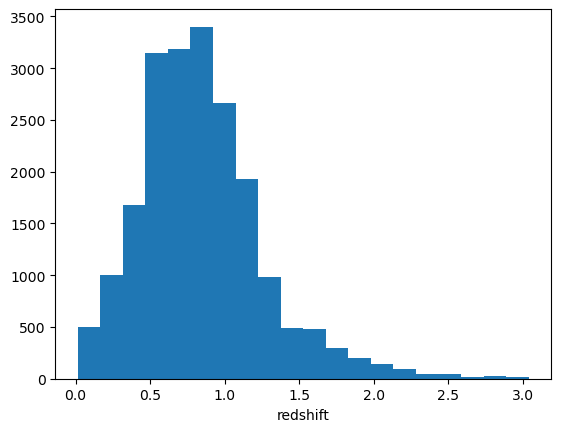

In [14]:
plt.hist(bckgd_galaxy_catalog_truth['redshift'], bins=20)
plt.xlabel('redshift')
plt.show()